In [1]:
# OS에 접근하기 위한 라이브러리
import os
# OS의 경로에 접근하기 위한 라이브러리
import os.path
# 경로 지정 라이브러리
from pathlib import Path
# 경고 메세지를 무시하기 위한 라이브러리
import warnings
warnings.filterwarnings("ignore")

# 데이터프레임 관리를 위한 라이브러리
import pandas as pd
# 연산을 위한 라이브러리
import numpy as np
# 그래프 등 출력 결과에 대한 시각화를 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

# 이미지 데이터 관리를 위한 라이브러리
import PIL

# 텐서 관리를 위한 라이브러리
import tensorflow as tf
# 모델 관리를 위한 라이브러리
from tensorflow import keras
# 모델 설계를 위한 모듈
from tensorflow.keras import layers,models
# 이미지 전처리를 위한 모듈
from tensorflow.keras.preprocessing import image
# 이미지 증강을 위한 모듈
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 모델 API
from tensorflow.keras.models import Sequential
# 모델 구조 설계를 위한 모듈
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
# 가중치 업데이트, 손실 함수를 위한 모듈
from tensorflow.keras import optimizers, losses

# 평가지표 시각화를 위한 모듈
from sklearn.metrics import classification_report, confusion_matrix
# 모델 학습을 위한 모듈
from sklearn.model_selection import StratifiedKFold
# 데이터를 섞기 위한 모듈
from sklearn.utils import shuffle


# 하이퍼 파라미터 값을 전역 변수로 선언
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 5
AUTO = tf.data.AUTOTUNE
EPOCHS = 50
KFOLD = 10

In [2]:
# 데이터 부모 디렉터리 경로 정의
data_dir = os.getenv('HOME') + '/aiffel/DL_Thon/jellyfish_extension'
image_dir = Path(data_dir)

# 경로 상에 있는 모든 JPG, jpg, jpeg, png, png 파일 경로를 가져와서 리스트 생성
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

# 파일 경로 상의 디렉터리 명으로 레이블 리스트 생성
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# 이미지 파일 경로 시리즈 정의
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
# 이미지 레이블 시리즈 정의
labels = pd.Series(labels, name='Label')

# 경로 시리즈와 레이블 시리즈로 데이터프레임 생성
image_df = pd.concat([filepaths, labels], axis=1)

# 생성된 데이터프레임 확인
image_df

,Filepath,Label
0,/aiffel/aiffel/DL_Thon/jellyfish_extension/Moo...,Moon_jellyfish
1,/aiffel/aiffel/DL_Thon/jellyfish_extension/Moo...,Moon_jellyfish
2,/aiffel/aiffel/DL_Thon/jellyfish_extension/Moo...,Moon_jellyfish
3,/aiffel/aiffel/DL_Thon/jellyfish_extension/Moo...,Moon_jellyfish
4,/aiffel/aiffel/DL_Thon/jellyfish_extension/Moo...,Moon_jellyfish
...,...,...
2217,/aiffel/aiffel/DL_Thon/jellyfish_extension/blu...,blue_jellyfish
2218,/aiffel/aiffel/DL_Thon/jellyfish_extension/blu...,blue_jellyfish
2219,/aiffel/aiffel/DL_Thon/jellyfish_extension/lio...,lions_mane_jellyfish
2220,/aiffel/aiffel/DL_Thon/jellyfish_extension/lio...,lions_mane_jellyfish


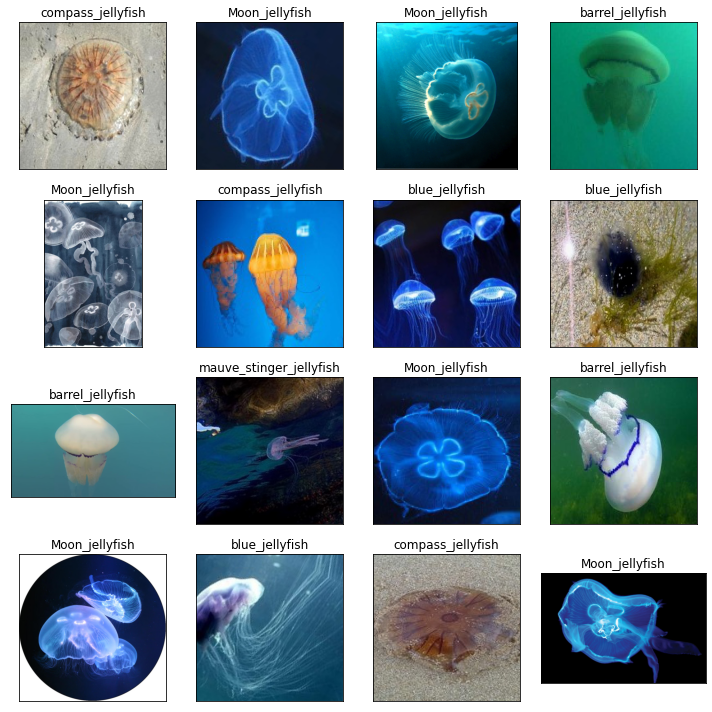

In [3]:
# 데이터프레임에서 무작위로 16개의 인덱스를 추첨하여 그에 해당하는 이미지와 레이블 출력
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Label', ylabel='count'>

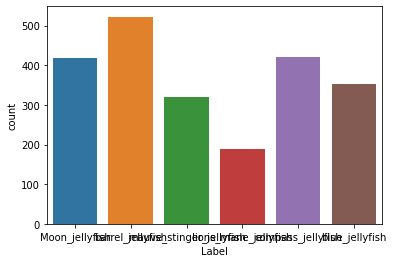

In [4]:
sns.countplot(data=image_df, x='Label') # 각각의 레이블 별 데이터 개수 확인

In [5]:
# 1. Set the `PYTHONHASHSEED` environment variable
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
np.random.seed(SEED)

# 3. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED)

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, # 픽셀값 정규화
                                   rotation_range = 40, # 회전 각도
                                   width_shift_range = 0.2, # 좌우 이동 범위
                                   height_shift_range = 0.2, # 상하 이동 범위
                                   shear_range = 0.2, # 기울기 범위
                                   zoom_range = 0.2, # 축소 범위
                                   horizontal_flip = False, # 상하 반전 여부 
                                   fill_mode = 'nearest', # 새로 생성되는 픽셀 값을 이웃 픽셀 값으로 지정
                                   validation_split=0.3) # 검증 데이터 분리 비율

In [7]:
# 훈련 데이터 증강
train_images = train_datagen.flow_from_directory(
    data_dir, # 데이터 경로
    target_size=(IMG_SIZE, IMG_SIZE), # 이미지 크기
    batch_size=BATCH_SIZE, # 배치 크기
    class_mode='categorical', # 다중분류
    subset='training') # 데이터 종류

validation_images = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

Found 1571 images belonging to 6 classes.
Found 669 images belonging to 6 classes.


In [8]:
mobile_model = Sequential()

# MobileNetV2 모델 가져오기
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3), # input data 형상
    include_top=False, # fully connected layer 배제
    weights='imagenet', # ImageNet 사전 훈련 가중치 사용
    pooling='avg' # 평균 풀링
)

pretrained_model.trainable = False # 사전 훈련 모델 프리징

mobile_model.add(pretrained_model) # 레이어에 추가

In [9]:
mobile_model.add(Flatten()) # Flatten 계층
mobile_model.add(Dense(512, activation='relu')) # Dense 계층
mobile_model.add(Dropout(0.2)) # 전체 뉴런의 80%만 사용
mobile_model.add(Dense(6, activation='softmax')) # 클래스가 총 6개이므로 출력 노드는 6으로 정의

mobile_model.summary() # 모델 구조 확인

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 2,916,934
Trainable params: 658,950
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
mobile_model.compile(loss = 'categorical_crossentropy', # 레이블이 정수형이 아니므로 categorical_crossentropy 손실함수 사용
                     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), # Adam 옵티마이저 학습률 0.001로 지정
                     metrics = ['accuracy']) # 평가지표는 정확도

Training on Fold 1
Epoch 1/4
50/50 [==============================] - 36s 629ms/step - loss: 0.9508 - accuracy: 0.6785 - val_loss: 0.5834 - val_accuracy: 0.7907
Epoch 2/4
50/50 [==============================] - 30s 598ms/step - loss: 0.4612 - accuracy: 0.8440 - val_loss: 0.5320 - val_accuracy: 0.8266
Epoch 3/4
50/50 [==============================] - 30s 603ms/step - loss: 0.3410 - accuracy: 0.8771 - val_loss: 0.5403 - val_accuracy: 0.8251
Epoch 4/4
21/21 [==============================] - 7s 340ms/step - loss: 0.4344 - accuracy: 0.8670
Training on Fold 2
Epoch 1/4
50/50 [==============================] - 31s 616ms/step - loss: 0.2717 - accuracy: 0.9045 - val_loss: 0.5137 - val_accuracy: 0.8356
Epoch 2/4
50/50 [==============================] - 30s 602ms/step - loss: 0.2452 - accuracy: 0.9102 - val_loss: 0.4739 - val_accuracy: 0.8520
Epoch 3/4
50/50 [==============================] - 30s 602ms/step - loss: 0.2094 - accuracy: 0.9306 - val_loss: 0.4238 - val_accuracy: 0.8924
Epoch 4/4
2

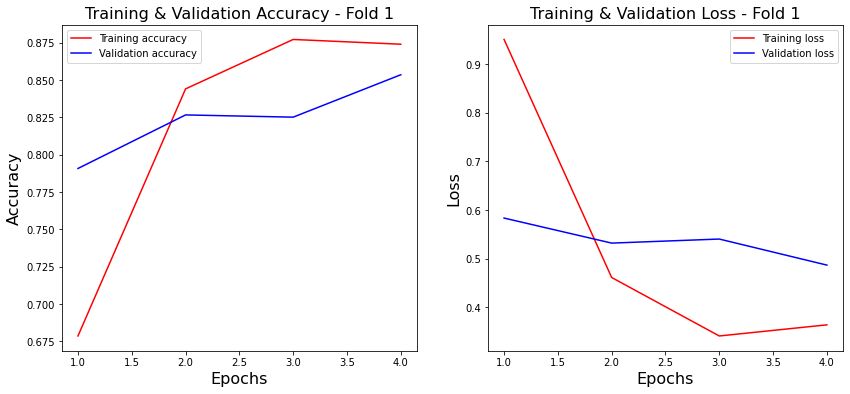

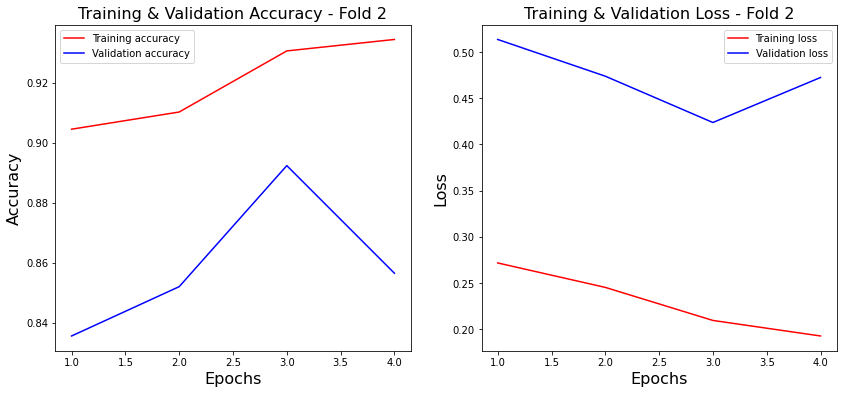

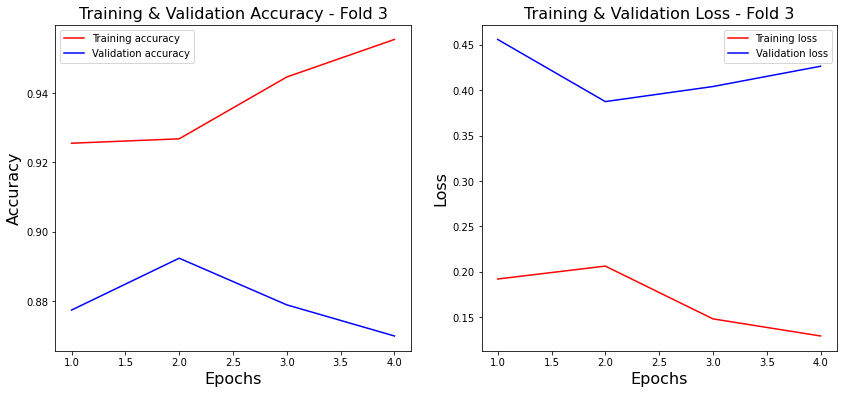

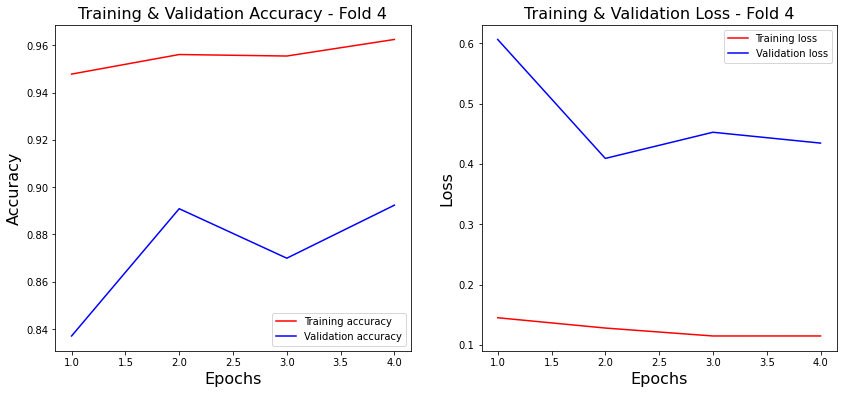

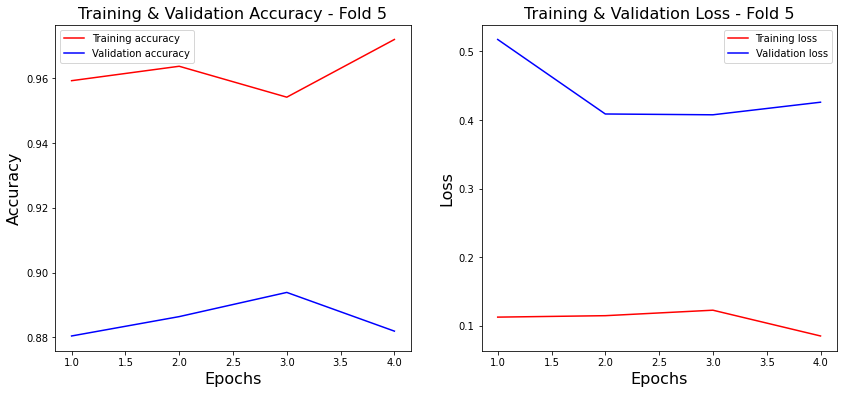

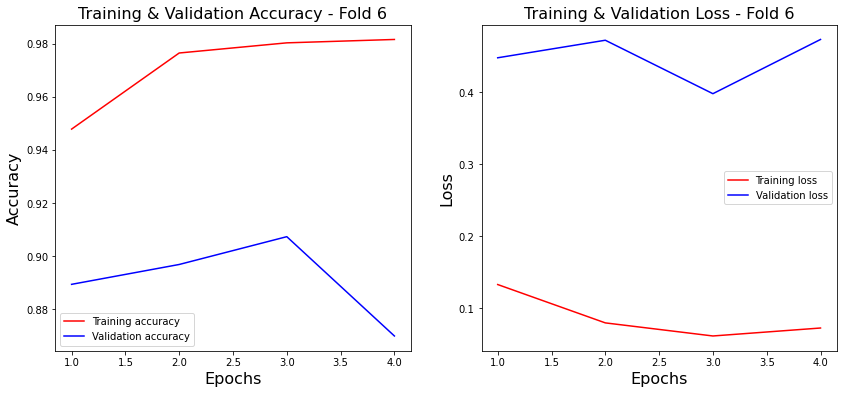

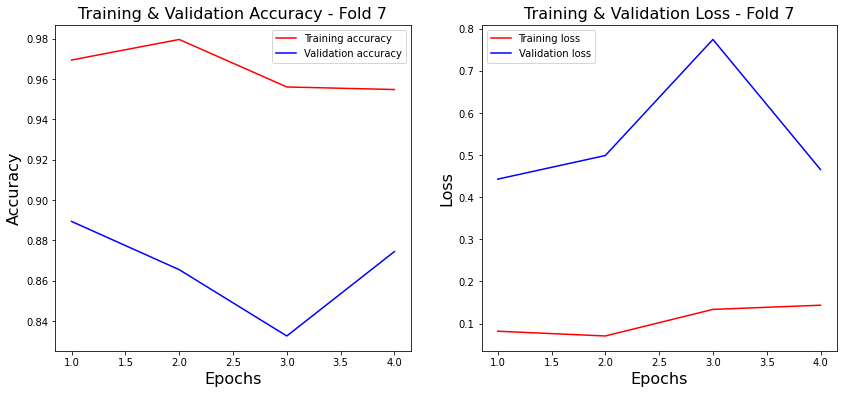

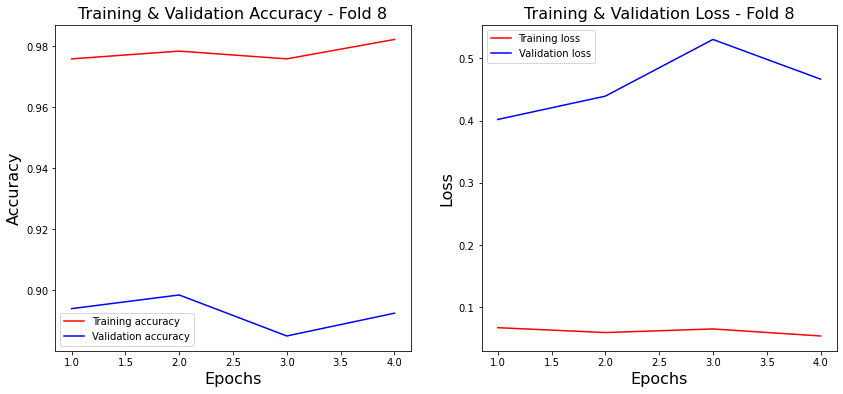

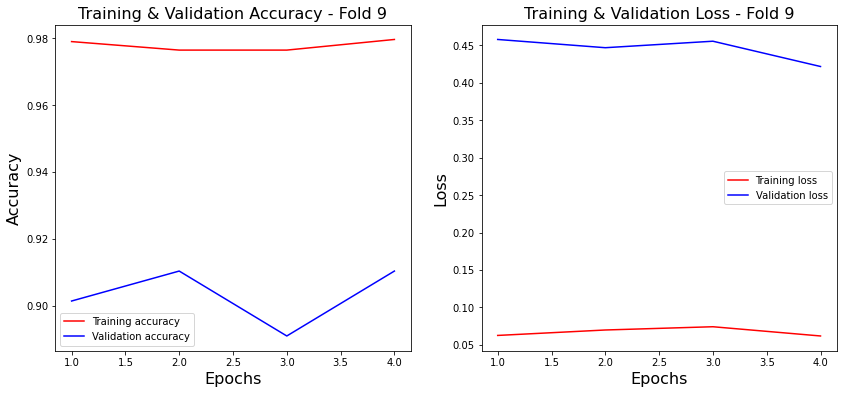

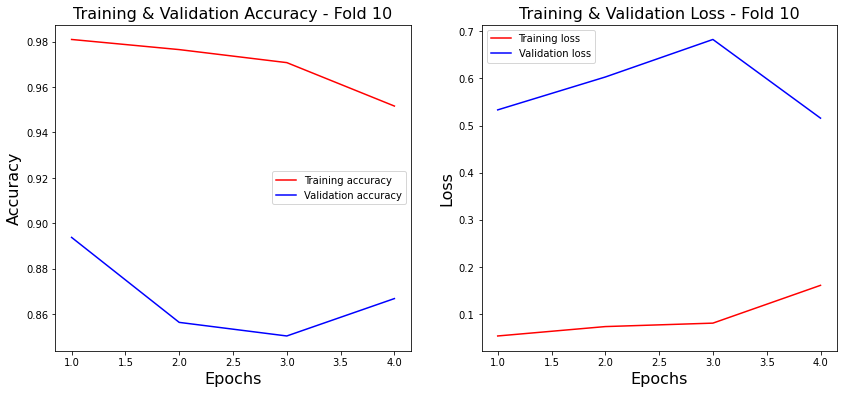

In [11]:
# 검증 정확도/손실값 리스트 초기화
all_validation_accuracy = []
all_validation_loss = []

# KFold 객체 생성
kf = StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=SEED)

# fold 반복
fold = 0
for train_index, val_index in kf.split(image_df.Filepath, image_df.Label):
    fold += 1
    print(f"Training on Fold {fold}")
    # 모델 학습 진행
    history = mobile_model.fit(train_images, steps_per_epoch=len(train_images), validation_data=validation_images, validation_steps=len(validation_images), epochs=4)

    # 검증 정확도/손실값 저장
    validation_loss, validation_accuracy = mobile_model.evaluate(validation_images, steps=len(validation_images))
    all_validation_accuracy.append(validation_accuracy)
    all_validation_loss.append(validation_loss)

    # fold 별 정확도/손실값 그래프 그리기
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # 에폭 별 정확도 그래프
    ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
    ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    ax[0].set_title(f'Training & Validation Accuracy - Fold {fold}', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Accuracy', fontsize=16)
    ax[0].legend()

    # 에폭 별 손실값 그래프
    ax[1].plot(epochs, loss_values, 'r', label='Training loss')
    ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
    ax[1].set_title(f'Training & Validation Loss - Fold {fold}', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Loss', fontsize=16)
    ax[1].legend()

In [15]:
# 제일 높은 정확도 찾기
best_acc = 0
for i in all_validation_accuracy:
    # 리스트의 다음 요소가 현재 best_acc보다 높으면 갱신
    if i > best_acc:
        best_acc = i

# 가장 정확도가 좋았던 fold의 인덱스와 정확도 출력
best_fold = np.argmax(all_validation_accuracy) + 1
print(f'Best Fold{best_fold} Accuracy: {best_acc}')

# 가장 정확도가 좋았던 fold의 인덱스와 손실값 출력
print(f'Best Fold{best_fold} Loss: {all_validation_loss[best_fold - 1]}')

Best Fold9 Accuracy: 0.8998505473136902
Best Fold9 Loss: 0.478945791721344


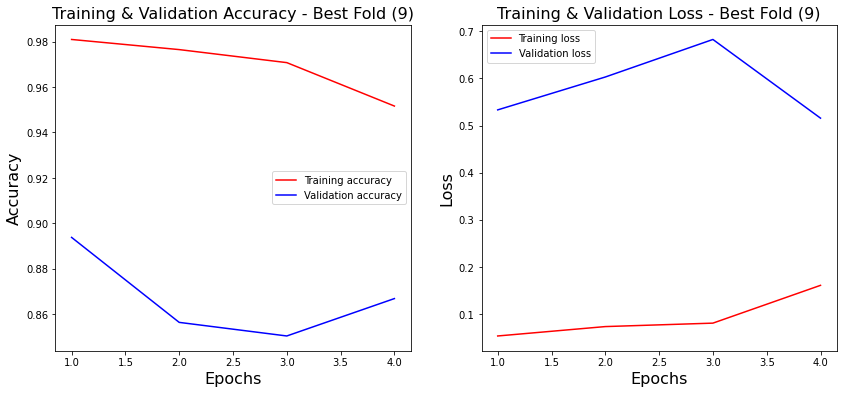

In [16]:
# 가장 결과가 좋았던 학습
best_fold_history = history

# 가장 성능이 좋았던 fold 학습/검증 정확도와 손실값 그래프 그리기
history_dict = best_fold_history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 에폭 별 정확도 그래프
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title(f'Training & Validation Accuracy - Best Fold ({best_acc_fold})', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# 에폭 별 손실값 그래프
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title(f'Training & Validation Loss - Best Fold ({best_acc_fold})', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

plt.show()

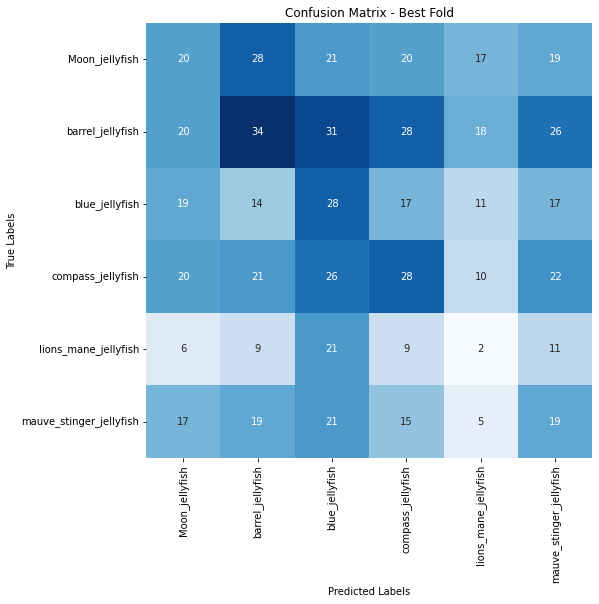

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 가장 결과가 좋았던 모델로 결과 예측
best_fold_validation_pred = mobile_model.predict(validation_images, steps=len(validation_images))
predicted_labels = np.argmax(best_fold_validation_pred, axis=1)

# 긍정 레이블
true_labels = validation_images.classes

# 가장 결과가 좋았던 fold의 혼동행렬
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# 혼동행렬 그리기
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=train_images.class_indices.keys(),
            yticklabels=train_images.class_indices.keys())
plt.title('Confusion Matrix - Best Fold')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()